## Binance Data Preparation

In [4]:
import requests
import pandas as pd
from datetime import datetime
import configparser
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd
import numpy as np

In [5]:
config_data=configparser.ConfigParser()
config_data.read("config.ini")
keys=config_data['keys']
client=Client(keys['apiKey'],keys['secretKey'])
print('logged in')

logged in


In [6]:
tickers=client.get_all_tickers()
tickers

[{'symbol': 'ETHBTC', 'price': '0.06426400'},
 {'symbol': 'LTCBTC', 'price': '0.00308600'},
 {'symbol': 'BNBBTC', 'price': '0.01071100'},
 {'symbol': 'NEOBTC', 'price': '0.00040900'},
 {'symbol': 'QTUMETH', 'price': '0.00166700'},
 {'symbol': 'EOSETH', 'price': '0.00063000'},
 {'symbol': 'SNTETH', 'price': '0.00001480'},
 {'symbol': 'BNTETH', 'price': '0.00027760'},
 {'symbol': 'BCCBTC', 'price': '0.07908100'},
 {'symbol': 'GASBTC', 'price': '0.00011280'},
 {'symbol': 'BNBETH', 'price': '0.16670000'},
 {'symbol': 'BTCUSDT', 'price': '29887.64000000'},
 {'symbol': 'ETHUSDT', 'price': '1920.80000000'},
 {'symbol': 'HSRBTC', 'price': '0.00041400'},
 {'symbol': 'OAXETH', 'price': '0.00017780'},
 {'symbol': 'DNTETH', 'price': '0.00002801'},
 {'symbol': 'MCOETH', 'price': '0.00577200'},
 {'symbol': 'ICNETH', 'price': '0.00166300'},
 {'symbol': 'MCOBTC', 'price': '0.00021140'},
 {'symbol': 'WTCBTC', 'price': '0.00000710'},
 {'symbol': 'WTCETH', 'price': '0.00023700'},
 {'symbol': 'LRCBTC', 'p

In [7]:
ticker_df=pd.DataFrame(tickers)
ticker_df

,symbol,price
0,ETHBTC,0.06426400
1,LTCBTC,0.00308600
2,BNBBTC,0.01071100
3,NEOBTC,0.00040900
4,QTUMETH,0.00166700
...,...,...
2183,SOLTUSD,23.68000000
2184,SSVTUSD,34.05000000
2185,RDNTBTC,0.00001039
2186,RDNTUSDT,0.31140000


In [8]:
ticker_df.set_index('symbol',inplace=True)

In [9]:
ticker_df

,price
symbol,
ETHBTC,0.06426400
LTCBTC,0.00308600
BNBBTC,0.01071100
NEOBTC,0.00040900
QTUMETH,0.00166700
...,...
SOLTUSD,23.68000000
SSVTUSD,34.05000000
RDNTBTC,0.00001039


In [10]:
depth=client.get_order_book(symbol='ETHBTC')
depth
depth_df=pd.DataFrame(depth['asks'])
depth_df.columns=['Price','Volume']
depth_df.head()

,Price,Volume
0,0.06426200,10.22360000
1,0.06426400,2.42630000
2,0.06426500,0.00340000
3,0.06426700,3.89630000
4,0.06426800,6.48750000


In [ ]:
#  [
#   [
#     1499040000000,      // Open time
#     "0.01634790",       // Open
#     "0.80000000",       // High
#     "0.01575800",       // Low
#     "0.01577100",       // Close
#     "148976.11427815",  // Volume
#     1499644799999,      // Close time
#     "2434.19055334",    // Quote asset volume
#     308,                // Number of trades
#     "1756.87402397",    // Taker buy base asset volume
#     "28.46694368",      // Taker buy quote asset volume
#     "17928899.62484339" // Ignore.
#   ]
# ]
client.get_historical_klines??

In [112]:
historical = client.get_historical_klines('BTCUSDT',Client.KLINE_INTERVAL_1DAY,'17 Aug 2017')# parameters:(symbol, interval, date_from)
historical

[[1502928000000,
  '4261.48000000',
  '4485.39000000',
  '4200.74000000',
  '4285.08000000',
  '795.15037700',
  1503014399999,
  '3454770.05073206',
  3427,
  '616.24854100',
  '2678216.40060401',
  '0'],
 [1503014400000,
  '4285.08000000',
  '4371.52000000',
  '3938.77000000',
  '4108.37000000',
  '1199.88826400',
  1503100799999,
  '5086958.30617151',
  5233,
  '972.86871000',
  '4129123.31651808',
  '0'],
 [1503100800000,
  '4108.37000000',
  '4184.69000000',
  '3850.00000000',
  '4139.98000000',
  '381.30976300',
  1503187199999,
  '1549483.73542151',
  2153,
  '274.33604200',
  '1118001.87008735',
  '0'],
 [1503187200000,
  '4120.98000000',
  '4211.08000000',
  '4032.62000000',
  '4086.29000000',
  '467.08302200',
  1503273599999,
  '1930364.39032646',
  2321,
  '376.79594700',
  '1557401.33373730',
  '0'],
 [1503273600000,
  '4069.13000000',
  '4119.62000000',
  '3911.79000000',
  '4016.00000000',
  '691.74306000',
  1503359999999,
  '2797231.71402728',
  3972,
  '557.35610700',

btcusdt is the price of bitcion relative to the US dollar; 1 usdt ~ 1 dollar; usdt was chosen because its price is tied to the dollar and does not fluctuate like other cryptocurrencies

In [113]:
hist_df=pd.DataFrame(historical)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1502928000000,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
1,1503014400000,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
2,1503100800000,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
3,1503187200000,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0
4,1503273600000,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,1503359999999,2797231.71402728,3972,557.35610700,2255662.55315837,0


In [114]:
hist_df.columns=['Open Time','Open','High','Low','Close','Volume','Close Time','Quote Asset Volume','Number of Trades','TB Base Volume','TB Quote Volume','Ignore']
hist_df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,1502928000000,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,1503014399999,3454770.05073206,3427,616.24854100,2678216.40060401,0
1,1503014400000,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,1503100799999,5086958.30617151,5233,972.86871000,4129123.31651808,0
2,1503100800000,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,1503187199999,1549483.73542151,2153,274.33604200,1118001.87008735,0
3,1503187200000,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,1503273599999,1930364.39032646,2321,376.79594700,1557401.33373730,0
4,1503273600000,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,1503359999999,2797231.71402728,3972,557.35610700,2255662.55315837,0


In [115]:
hist_df.shape

(2066, 12)

In [116]:
hist_df.dtypes #int64 + objects (which are strings) >> preprocessing

Open Time              int64
Open                  object
High                  object
Low                   object
Close                 object
Volume                object
Close Time             int64
Quote Asset Volume    object
Number of Trades       int64
TB Base Volume        object
TB Quote Volume       object
Ignore                object
dtype: object

In [117]:
#convert from Unix timestamps to date
hist_df['Open Time']= pd.to_datetime(hist_df['Open Time']/1000, unit='s')
hist_df['Close Time']= pd.to_datetime(hist_df['Close Time']/1000, unit='s')
hist_df.dtypes

Open Time             datetime64[ns]
Open                          object
High                          object
Low                           object
Close                         object
Volume                        object
Close Time            datetime64[ns]
Quote Asset Volume            object
Number of Trades               int64
TB Base Volume                object
TB Quote Volume               object
Ignore                        object
dtype: object

In [118]:
hist_df.head() #notice open time and close time 

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2017-08-17,4261.48000000,4485.39000000,4200.74000000,4285.08000000,795.15037700,2017-08-17 23:59:59.999000064,3454770.05073206,3427,616.24854100,2678216.40060401,0
1,2017-08-18,4285.08000000,4371.52000000,3938.77000000,4108.37000000,1199.88826400,2017-08-18 23:59:59.999000064,5086958.30617151,5233,972.86871000,4129123.31651808,0
2,2017-08-19,4108.37000000,4184.69000000,3850.00000000,4139.98000000,381.30976300,2017-08-19 23:59:59.999000064,1549483.73542151,2153,274.33604200,1118001.87008735,0
3,2017-08-20,4120.98000000,4211.08000000,4032.62000000,4086.29000000,467.08302200,2017-08-20 23:59:59.999000064,1930364.39032646,2321,376.79594700,1557401.33373730,0
4,2017-08-21,4069.13000000,4119.62000000,3911.79000000,4016.00000000,691.74306000,2017-08-21 23:59:59.999000064,2797231.71402728,3972,557.35610700,2255662.55315837,0


Binance was launched in July 2017 and therefore the historical data for trading pairs listed on Binance is available from the time the exchange began operations.

In [119]:
numeric_columns=['Open','High','Low','Close','Volume','Quote Asset Volume','TB Base Volume','TB Quote Volume']
hist_df[numeric_columns]=hist_df[numeric_columns].apply(pd.to_numeric,axis=1)
hist_df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.454770e+06,3427,616.248541,2.678216e+06,0
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.086958e+06,5233,972.868710,4.129123e+06,0
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.549484e+06,2153,274.336042,1.118002e+06,0
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.930364e+06,2321,376.795947,1.557401e+06,0
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.797232e+06,3972,557.356107,2.255663e+06,0


In [120]:
hist_df.dtypes

Open Time             datetime64[ns]
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                       float64
Close Time            datetime64[ns]
Quote Asset Volume           float64
Number of Trades               int64
TB Base Volume               float64
TB Quote Volume              float64
Ignore                        object
dtype: object

In [121]:
hist_df.describe()

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume
count,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000,2.066000e+03,2.066000e+03,2066.000000,2.066000e+03
mean,19623.700939,20168.481312,19009.848659,19636.321394,77764.754810,1.683820e+09,1.490657e+06,38715.377773,8.349330e+08
std,16353.862721,16803.579732,15833.765060,16352.081708,88548.598296,2.160337e+09,2.105949e+06,44031.935667,1.072781e+09
min,3188.010000,3276.500000,2817.000000,3189.020000,228.108068,9.778657e+05,2.153000e+03,56.190141,2.413638e+05
25%,7412.305000,7651.250000,7266.127500,7418.957500,31318.292865,2.567069e+08,2.672105e+05,15802.945650,1.303418e+08
50%,11063.975000,11455.580000,10755.930000,11076.000000,48645.327020,6.496241e+08,7.107185e+05,24425.403173,3.232776e+08
75%,29462.342500,30324.702500,28746.252500,29523.637500,83010.292932,2.491345e+09,1.644285e+06,41099.979941,1.247839e+09
max,67525.820000,69000.000000,66222.400000,67525.830000,760705.362783,1.746531e+10,1.522359e+07,374775.574085,8.783916e+09


In [122]:
hist_df.describe(include='object')

,Ignore
count,2066
unique,1
top,0
freq,2066


In [123]:
hist_df.describe(include='datetime')

C:\Users\Layan\AppData\Local\Temp\ipykernel_6408\1561694266.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hist_df.describe(include='datetime')
C:\Users\Layan\AppData\Local\Temp\ipykernel_6408\1561694266.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hist_df.describe(include='datetime')


,Open Time,Close Time
count,2066,2066
unique,2066,2066
top,2017-08-17 00:00:00,2017-08-17 23:59:59.999000064
freq,1,1
first,2017-08-17 00:00:00,2017-08-17 23:59:59.999000064
last,2023-04-13 00:00:00,2023-04-13 23:59:59.999000064


In [124]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Open Time           2066 non-null   datetime64[ns]
 1   Open                2066 non-null   float64       
 2   High                2066 non-null   float64       
 3   Low                 2066 non-null   float64       
 4   Close               2066 non-null   float64       
 5   Volume              2066 non-null   float64       
 6   Close Time          2066 non-null   datetime64[ns]
 7   Quote Asset Volume  2066 non-null   float64       
 8   Number of Trades    2066 non-null   int64         
 9   TB Base Volume      2066 non-null   float64       
 10  TB Quote Volume     2066 non-null   float64       
 11  Ignore              2066 non-null   object        
dtypes: datetime64[ns](2), float64(8), int64(1), object(1)
memory usage: 193.8+ KB


In [125]:
hist_df.set_index('Open Time', inplace=True)

In [126]:
hist_df['Weighted Avg Price'] = hist_df['Quote Asset Volume'] / hist_df['Volume'] #SIMILAR METRIC TO BPI

In [127]:
hist_df.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore,Weighted Avg Price
Open Time,,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.454770e+06,3427,616.248541,2.678216e+06,0,4344.800871
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.086958e+06,5233,972.868710,4.129123e+06,0,4239.526678
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.549484e+06,2153,274.336042,1.118002e+06,0,4063.582645
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.930364e+06,2321,376.795947,1.557401e+06,0,4132.807872
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.797232e+06,3972,557.356107,2.255663e+06,0,4043.743806


In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Layan\AppData\Local\Temp\ipykernel_6408\1260550089.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = hist_df.corr()


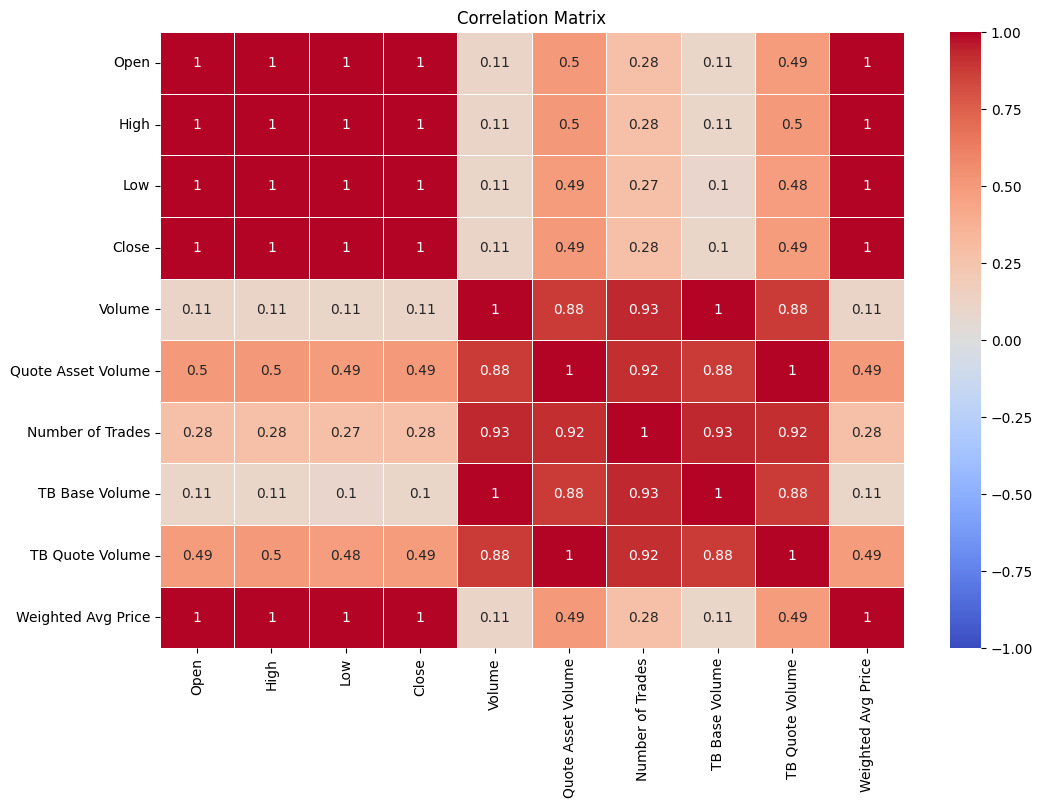

In [129]:
correlations = hist_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [30]:
data_csv=hist_df.drop(['Quote Asset Volume','TB Quote Volume','Number of Trades','TB Base Volume','Close Time','Ignore'],axis=1)
data_csv.to_csv('btc_prediction_data.csv')
data_csv

,Open,High,Low,Close,Volume,Weighted Avg Price
Open Time,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,4344.800871
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,4239.526678
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,4063.582645
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,4132.807872
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,4043.743806
...,...,...,...,...,...,...
2023-04-08,27906.34,28154.99,27859.02,27938.38,19479.967350,27994.118721
2023-04-09,27938.38,28530.00,27800.00,28323.76,32531.161010,28093.553852
2023-04-10,28323.76,29770.00,28170.00,29637.34,67754.062200,28858.800191


## Blockchain Data Preparation from Blockchain.com

In [31]:

features = [
    "avg-block-size",
    "blockchain-size",
    "blocks-size",
    "cost-per-transaction",
    "cost-per-transaction-percent",
    "difficulty",
    "estimated-transaction-volume",
    "estimated-transaction-volume-usd",
    "hash-rate",
    "n-transactions-total",
    "market-price",
    "n-unique-addresses",
    "n-transactions-per-block",
    "n-transactions",
    "miners-revenue",
    "transaction-fees",
    "transaction-fees-usd",
    "n-transactions-excluding-popular",
    "n-transactions-excluding-chains-longer-than-100",
    "output-volume",
    "total-bitcoins",
    "trade-volume"
]

In [32]:
def fetch_data(feature):
    url = f"https://api.blockchain.info/charts/market-price?timespan=6years&format=json"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        return data["values"]
    else:
        print(f"Error fetching {feature}: {response.status_code}")
        return []

In [33]:
dataframes = []
for feature in features:
    data = fetch_data(feature)
    
    if data:
        df = pd.DataFrame(data)
        df["feature"] = feature
        dataframes.append(df)

blockchainData_df = pd.concat(dataframes, ignore_index=True)
blockchainData_df.rename(columns={"x": "timestamp", "y": "value"}, inplace=True)

print(blockchainData_df)

        timestamp     value         feature
0      1492041600   1212.17  avg-block-size
1      1492128000   1174.43  avg-block-size
2      1492214400   1170.36  avg-block-size
3      1492300800   1190.50  avg-block-size
4      1492387200   1161.10  avg-block-size
...           ...       ...             ...
48197  1680912000  27925.55    trade-volume
48198  1680998400  27956.01    trade-volume
48199  1681084800  28336.18    trade-volume
48200  1681171200  29656.24    trade-volume
48201  1681257600  30234.98    trade-volume

[48202 rows x 3 columns]


In [34]:
blockchainData_df["timestamp"] = pd.to_datetime(blockchainData_df["timestamp"], unit="s")
blockchainData_df

,timestamp,value,feature
0,2017-04-13,1212.17,avg-block-size
1,2017-04-14,1174.43,avg-block-size
2,2017-04-15,1170.36,avg-block-size
3,2017-04-16,1190.50,avg-block-size
4,2017-04-17,1161.10,avg-block-size
...,...,...,...
48197,2023-04-08,27925.55,trade-volume
48198,2023-04-09,27956.01,trade-volume
48199,2023-04-10,28336.18,trade-volume
48200,2023-04-11,29656.24,trade-volume


In [35]:
blockchainData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48202 entries, 0 to 48201
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  48202 non-null  datetime64[ns]
 1   value      48202 non-null  float64       
 2   feature    48202 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ MB


In [36]:
blockchainData_df.feature.unique()

array(['avg-block-size', 'blockchain-size', 'blocks-size',
       'cost-per-transaction', 'cost-per-transaction-percent',
       'difficulty', 'estimated-transaction-volume',
       'estimated-transaction-volume-usd', 'hash-rate',
       'n-transactions-total', 'market-price', 'n-unique-addresses',
       'n-transactions-per-block', 'n-transactions', 'miners-revenue',
       'transaction-fees', 'transaction-fees-usd',
       'n-transactions-excluding-popular',
       'n-transactions-excluding-chains-longer-than-100', 'output-volume',
       'total-bitcoins', 'trade-volume'], dtype=object)

In [37]:
blockchainData_df.set_index('timestamp')

,value,feature
timestamp,,
2017-04-13,1212.17,avg-block-size
2017-04-14,1174.43,avg-block-size
2017-04-15,1170.36,avg-block-size
2017-04-16,1190.50,avg-block-size
2017-04-17,1161.10,avg-block-size
...,...,...
2023-04-08,27925.55,trade-volume
2023-04-09,27956.01,trade-volume
2023-04-10,28336.18,trade-volume


In [38]:
pivoted_df = blockchainData_df.pivot_table(index="timestamp", columns="feature", values="value")

In [39]:
pivoted_df

feature,avg-block-size,blockchain-size,blocks-size,cost-per-transaction,cost-per-transaction-percent,difficulty,estimated-transaction-volume,estimated-transaction-volume-usd,hash-rate,market-price,...,n-transactions-excluding-chains-longer-than-100,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-unique-addresses,output-volume,total-bitcoins,trade-volume,transaction-fees,transaction-fees-usd
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-04-13,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,...,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17,1212.17
2017-04-14,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,...,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43,1174.43
2017-04-15,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,...,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36,1170.36
2017-04-16,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,...,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50,1190.50
2017-04-17,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,...,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10,1161.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-08,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,...,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55
2023-04-09,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,...,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01
2023-04-10,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,...,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18


In [40]:
pivoted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2191 entries, 2017-04-13 to 2023-04-12
Data columns (total 22 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   avg-block-size                                   2191 non-null   float64
 1   blockchain-size                                  2191 non-null   float64
 2   blocks-size                                      2191 non-null   float64
 3   cost-per-transaction                             2191 non-null   float64
 4   cost-per-transaction-percent                     2191 non-null   float64
 5   difficulty                                       2191 non-null   float64
 6   estimated-transaction-volume                     2191 non-null   float64
 7   estimated-transaction-volume-usd                 2191 non-null   float64
 8   hash-rate                                        2191 non-null   float64
 9   market-price

In [41]:
pivoted_df.describe()

feature,avg-block-size,blockchain-size,blocks-size,cost-per-transaction,cost-per-transaction-percent,difficulty,estimated-transaction-volume,estimated-transaction-volume-usd,hash-rate,market-price,...,n-transactions-excluding-chains-longer-than-100,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-unique-addresses,output-volume,total-bitcoins,trade-volume,transaction-fees,transaction-fees-usd
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,...,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,...,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264,18634.722264
std,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,...,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396,16393.441396
min,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,...,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000,1161.100000
25%,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,...,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000,6855.925000
50%,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,...,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000,10420.160000
75%,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,...,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000,27643.545000
max,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,...,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000,67562.170000


In [42]:
num_years = (blockchainData_df["timestamp"].max() - blockchainData_df["timestamp"].min()).total_seconds() / (365.25 * 24 * 60 * 60)
num_years 

5.9958932238193015

## Merging the Data

In [63]:
mergedData_df = pd.merge(hist_df, pivoted_df, left_index=True, right_index=True)
mergedData_df                     

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,...,n-transactions-excluding-chains-longer-than-100,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-unique-addresses,output-volume,total-bitcoins,trade-volume,transaction-fees,transaction-fees-usd
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.454770e+06,3427,616.248541,2.678216e+06,...,4375.80,4375.80,4375.80,4375.80,4375.80,4375.80,4375.80,4375.80,4375.80,4375.80
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.086958e+06,5233,972.868710,4.129123e+06,...,4279.79,4279.79,4279.79,4279.79,4279.79,4279.79,4279.79,4279.79,4279.79,4279.79
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.549484e+06,2153,274.336042,1.118002e+06,...,4104.71,4104.71,4104.71,4104.71,4104.71,4104.71,4104.71,4104.71,4104.71,4104.71
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.930364e+06,2321,376.795947,1.557401e+06,...,4146.09,4146.09,4146.09,4146.09,4146.09,4146.09,4146.09,4146.09,4146.09,4146.09
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.797232e+06,3972,557.356107,2.255663e+06,...,4054.60,4054.60,4054.60,4054.60,4054.60,4054.60,4054.60,4054.60,4054.60,4054.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-08,27906.34,28154.99,27859.02,27938.38,19479.967350,2023-04-08 23:59:59.999000064,5.453245e+08,624159,9729.242140,2.723667e+08,...,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55,27925.55
2023-04-09,27938.38,28530.00,27800.00,28323.76,32531.161010,2023-04-09 23:59:59.999000064,9.139159e+08,777589,16885.707570,4.744543e+08,...,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01,27956.01
2023-04-10,28323.76,29770.00,28170.00,29637.34,67754.062200,2023-04-10 23:59:59.999000064,1.955301e+09,1285695,36147.623260,1.043139e+09,...,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18,28336.18
2023-04-11,29637.35,30550.00,29590.00,30200.42,67990.076210,2023-04-11 23:59:59.999000064,2.046078e+09,1340458,34766.927180,1.046251e+09,...,29656.24,29656.24,29656.24,29656.24,29656.24,29656.24,29656.24,29656.24,29656.24,29656.24


In [64]:
mergedData_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2017-08-17 to 2023-04-12
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Open                                             2065 non-null   float64       
 1   High                                             2065 non-null   float64       
 2   Low                                              2065 non-null   float64       
 3   Close                                            2065 non-null   float64       
 4   Volume                                           2065 non-null   float64       
 5   Close Time                                       2065 non-null   datetime64[ns]
 6   Quote Asset Volume                               2065 non-null   float64       
 7   Number of Trades                                 2065 non-null   int64         
 8   TB Base Volume      

C:\Users\Layan\AppData\Local\Temp\ipykernel_6408\3653368301.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = mergedData_df.corr()


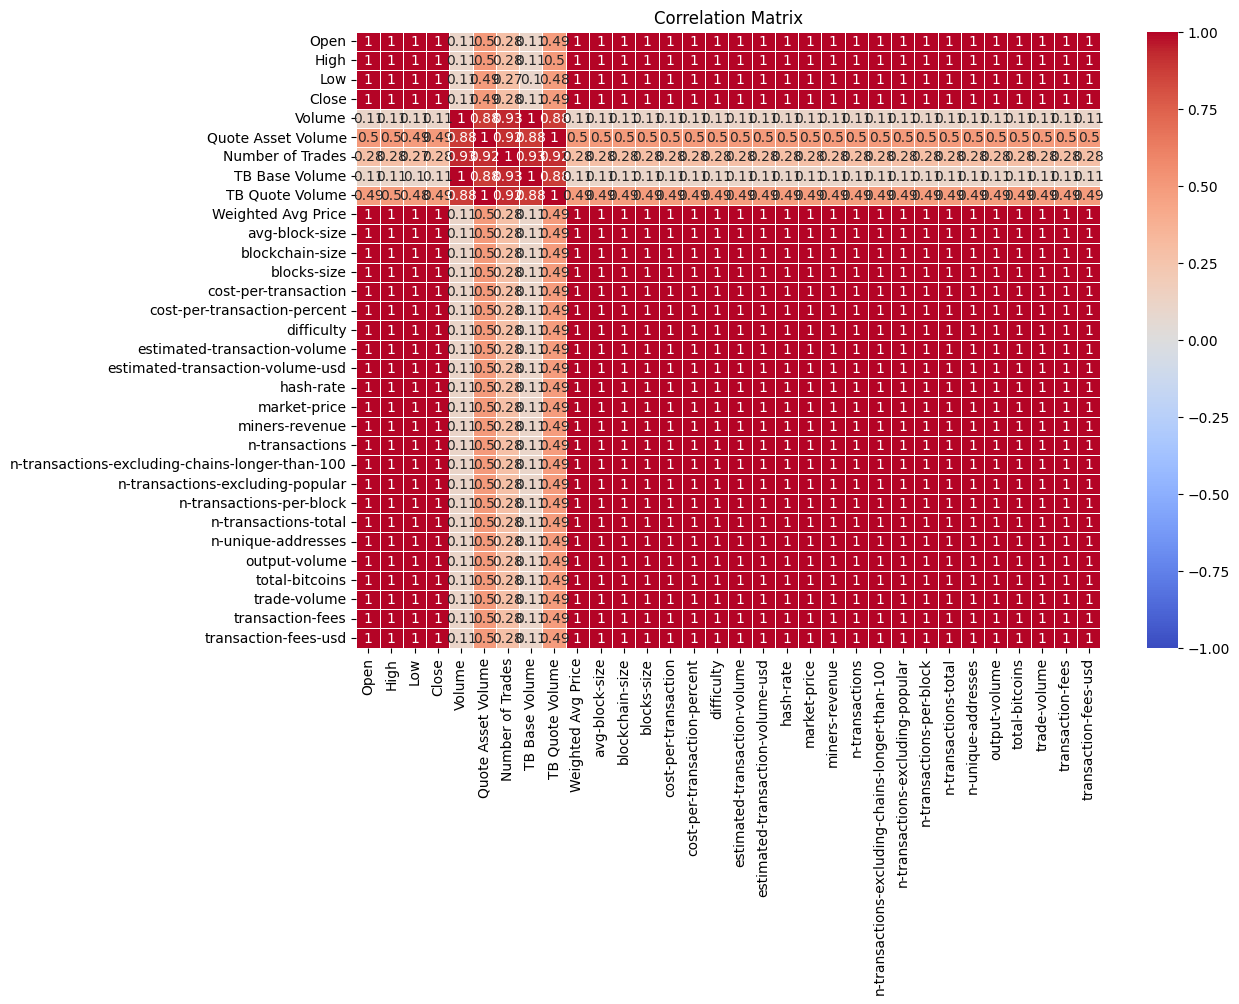

In [45]:
correlations = mergedData_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [46]:
correlations['market-price']

Open                                               0.999994
High                                               0.999240
Low                                                0.998500
Close                                              0.998199
Volume                                             0.110717
Quote Asset Volume                                 0.496323
Number of Trades                                   0.275790
TB Base Volume                                     0.105378
TB Quote Volume                                    0.491126
Weighted Avg Price                                 0.999245
avg-block-size                                     1.000000
blockchain-size                                    1.000000
blocks-size                                        1.000000
cost-per-transaction                               1.000000
cost-per-transaction-percent                       1.000000
difficulty                                         1.000000
estimated-transaction-volume            

In [47]:
mergedData_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
       'Quote Asset Volume', 'Number of Trades', 'TB Base Volume',
       'TB Quote Volume', 'Ignore', 'Weighted Avg Price', 'avg-block-size',
       'blockchain-size', 'blocks-size', 'cost-per-transaction',
       'cost-per-transaction-percent', 'difficulty',
       'estimated-transaction-volume', 'estimated-transaction-volume-usd',
       'hash-rate', 'market-price', 'miners-revenue', 'n-transactions',
       'n-transactions-excluding-chains-longer-than-100',
       'n-transactions-excluding-popular', 'n-transactions-per-block',
       'n-transactions-total', 'n-unique-addresses', 'output-volume',
       'total-bitcoins', 'trade-volume', 'transaction-fees',
       'transaction-fees-usd'],
      dtype='object')

In [48]:
mergedData_df.drop(columns=['Quote Asset Volume', 'Number of Trades', 'TB Base Volume',
       'TB Quote Volume', 'Ignore','Close Time'],inplace=True)

## technical indicators 

In [76]:
#calculate the EMA
mergedData_df['EMA'] = mergedData_df['Close'].ewm(span=12).mean()
mergedData_df.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,...,total-bitcoins,trade-volume,transaction-fees,transaction-fees-usd,%K,PROC,MOM,RSI,MACD,EMA
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.454770e+06,3427,616.248541,2.678216e+06,...,4375.80,4375.80,4375.80,4375.80,NaN,NaN,NaN,NaN,0.000000,4285.080000
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.086958e+06,5233,972.868710,4.129123e+06,...,4279.79,4279.79,4279.79,4279.79,NaN,NaN,NaN,NaN,-3.964647,4189.362083
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.549484e+06,2153,274.336042,1.118002e+06,...,4104.71,4104.71,4104.71,4104.71,NaN,NaN,NaN,NaN,-4.071524,4170.088245
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.930364e+06,2321,376.795947,1.557401e+06,...,4146.09,4146.09,4146.09,4146.09,NaN,NaN,NaN,NaN,-5.958807,4143.636414
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.797232e+06,3972,557.356107,2.255663e+06,...,4054.60,4054.60,4054.60,4054.60,NaN,NaN,NaN,NaN,-9.655882,4108.958056


In [74]:
#calculate the MACD
temp_df=pd.DataFrame()
temp_df['EMA_12'] = mergedData_df['Close'].ewm(span=12).mean()
temp_df['EMA_26'] = mergedData_df['Close'].ewm(span=26).mean()
mergedData_df['MACD'] = temp_df['EMA_12'] - temp_df['EMA_26']
mergedData_df

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,...,output-volume,total-bitcoins,trade-volume,transaction-fees,transaction-fees-usd,%K,PROC,MOM,RSI,MACD
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999000064,3.454770e+06,3427,616.248541,2.678216e+06,...,4375.80,4375.80,4375.80,4375.80,4375.80,NaN,NaN,NaN,NaN,0.000000
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999000064,5.086958e+06,5233,972.868710,4.129123e+06,...,4279.79,4279.79,4279.79,4279.79,4279.79,NaN,NaN,NaN,NaN,-3.964647
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999000064,1.549484e+06,2153,274.336042,1.118002e+06,...,4104.71,4104.71,4104.71,4104.71,4104.71,NaN,NaN,NaN,NaN,-4.071524
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999000064,1.930364e+06,2321,376.795947,1.557401e+06,...,4146.09,4146.09,4146.09,4146.09,4146.09,NaN,NaN,NaN,NaN,-5.958807
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999000064,2.797232e+06,3972,557.356107,2.255663e+06,...,4054.60,4054.60,4054.60,4054.60,4054.60,NaN,NaN,NaN,NaN,-9.655882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-08,27906.34,28154.99,27859.02,27938.38,19479.967350,2023-04-08 23:59:59.999000064,5.453245e+08,624159,9729.242140,2.723667e+08,...,27925.55,27925.55,27925.55,27925.55,27925.55,53.436153,1.731169,-410.22,55.101257,810.833968
2023-04-09,27938.38,28530.00,27800.00,28323.76,32531.161010,2023-04-09 23:59:59.999000064,9.139159e+08,777589,16885.707570,4.744543e+08,...,27956.01,27956.01,27956.01,27956.01,27956.01,67.834592,1.271844,295.23,53.917330,785.302239
2023-04-10,28323.76,29770.00,28170.00,29637.34,67754.062200,2023-04-10 23:59:59.999000064,1.955301e+09,1285695,36147.623260,1.043139e+09,...,28336.18,28336.18,28336.18,28336.18,28336.18,95.772763,9.262445,1171.98,75.070899,861.136443
2023-04-11,29637.35,30550.00,29590.00,30200.42,67990.076210,2023-04-11 23:59:59.999000064,2.046078e+09,1340458,34766.927180,1.046251e+09,...,29656.24,29656.24,29656.24,29656.24,29656.24,89.564028,10.782225,1747.69,77.028158,955.655247


In [77]:
#Calculate the RSI
price_changes = mergedData_df['Close'].diff()
positive_changes = price_changes.where(price_changes > 0, 0)
negative_changes = -price_changes.where(price_changes < 0, 0)
temp_df['avg_positive_changes'] = positive_changes.rolling(window=14).mean()
temp_df['avg_negative_changes'] = negative_changes.rolling(window=14).mean()
temp_df['RS'] = temp_df['avg_positive_changes'] / temp_df['avg_negative_changes']#NaN 
mergedData_df['RSI'] = 100 - (100 / (1 + temp_df['RS']))
mergedData_df.info() #null values 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2017-08-17 to 2023-04-12
Data columns (total 40 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Open                                             2065 non-null   float64       
 1   High                                             2065 non-null   float64       
 2   Low                                              2065 non-null   float64       
 3   Close                                            2065 non-null   float64       
 4   Volume                                           2065 non-null   float64       
 5   Close Time                                       2065 non-null   datetime64[ns]
 6   Quote Asset Volume                               2065 non-null   float64       
 7   Number of Trades                                 2065 non-null   int64         
 8   TB Base Volume      

In [53]:
price_changes.where(price_changes>0,0).rolling(window=14).mean()

2017-08-17           NaN
2017-08-18           NaN
2017-08-19           NaN
2017-08-20           NaN
2017-08-21           NaN
                 ...    
2023-04-08    183.405714
2023-04-09    174.854286
2023-04-10    268.681429
2023-04-11    299.175714
2023-04-12    221.495000
Name: Close, Length: 2065, dtype: float64

In [71]:
N = 10  # You can set the desired N value for the momentum calculation
mergedData_df['MOM'] = mergedData_df['Close'] - mergedData_df['Close'].shift(N)
mergedData_df.info() #new null values 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2017-08-17 to 2023-04-12
Data columns (total 37 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Open                                             2065 non-null   float64       
 1   High                                             2065 non-null   float64       
 2   Low                                              2065 non-null   float64       
 3   Close                                            2065 non-null   float64       
 4   Volume                                           2065 non-null   float64       
 5   Close Time                                       2065 non-null   datetime64[ns]
 6   Quote Asset Volume                               2065 non-null   float64       
 7   Number of Trades                                 2065 non-null   int64         
 8   TB Base Volume      

In [55]:
null_indices = mergedData_df[mergedData_df.isnull().any(axis=1)].reset_index()["index"].tolist()
null_indices #13 rows, rolling window is of size 14 

[Timestamp('2017-08-17 00:00:00'),
 Timestamp('2017-08-18 00:00:00'),
 Timestamp('2017-08-19 00:00:00'),
 Timestamp('2017-08-20 00:00:00'),
 Timestamp('2017-08-21 00:00:00'),
 Timestamp('2017-08-22 00:00:00'),
 Timestamp('2017-08-23 00:00:00'),
 Timestamp('2017-08-24 00:00:00'),
 Timestamp('2017-08-25 00:00:00'),
 Timestamp('2017-08-26 00:00:00'),
 Timestamp('2017-08-27 00:00:00'),
 Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-08-29 00:00:00')]

In [70]:
N = 14  # You can set the desired N value for the PROC calculation
mergedData_df['PROC'] = (mergedData_df['Close'] - mergedData_df['Close'].shift(N)) / mergedData_df['Close'].shift(N) * 100
mergedData_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2017-08-17 to 2023-04-12
Data columns (total 36 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Open                                             2065 non-null   float64       
 1   High                                             2065 non-null   float64       
 2   Low                                              2065 non-null   float64       
 3   Close                                            2065 non-null   float64       
 4   Volume                                           2065 non-null   float64       
 5   Close Time                                       2065 non-null   datetime64[ns]
 6   Quote Asset Volume                               2065 non-null   float64       
 7   Number of Trades                                 2065 non-null   int64         
 8   TB Base Volume      

In [66]:
N = 14  # You can set the desired N value for the %K calculation
low_N = mergedData_df['Low'].rolling(window=N).min()
high_N = mergedData_df['High'].rolling(window=N).max()
mergedData_df['%K'] = (mergedData_df['Close'] - low_N) / (high_N - low_N) * 100
mergedData_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2065 entries, 2017-08-17 to 2023-04-12
Data columns (total 35 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Open                                             2065 non-null   float64       
 1   High                                             2065 non-null   float64       
 2   Low                                              2065 non-null   float64       
 3   Close                                            2065 non-null   float64       
 4   Volume                                           2065 non-null   float64       
 5   Close Time                                       2065 non-null   datetime64[ns]
 6   Quote Asset Volume                               2065 non-null   float64       
 7   Number of Trades                                 2065 non-null   int64         
 8   TB Base Volume      

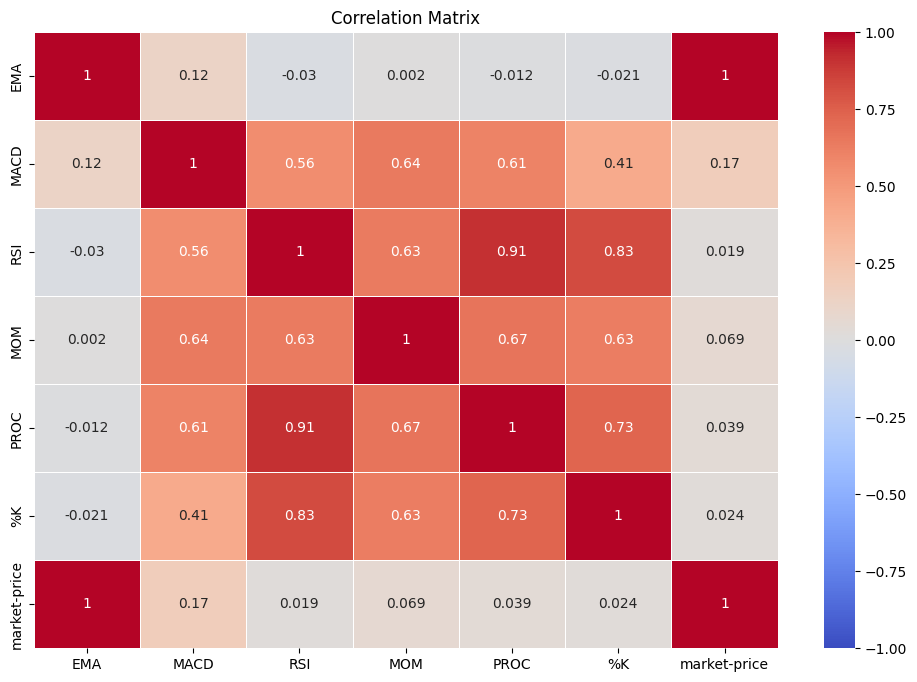

In [61]:
sub_df=mergedData_df[['EMA','MACD','RSI','MOM','PROC','%K','market-price']]
correlations = sub_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [78]:
csv_file=mergedData_df.to_csv('data_with_tecInd.csv')
csv_file

In [132]:
mergedData_df.dropna(inplace=True)

In [133]:
csv_file=mergedData_df.to_csv('data_with_tecInd.csv')
csv_file

In [134]:
mergedData_df

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,...,total-bitcoins,trade-volume,transaction-fees,transaction-fees-usd,%K,PROC,MOM,RSI,MACD,EMA
2017-08-31,4555.14,4745.42,4555.14,4724.89,556.956802,2017-08-31 23:59:59.999000064,2.579879e+06,4161,131.947325,6.143425e+05,...,4582.52,4582.52,4582.52,4582.52,98.474082,10.263752,708.89,67.858274,69.071491,4413.810791
2017-09-01,4689.89,4885.55,4654.88,4834.91,560.666366,2017-09-01 23:59:59.999000064,2.665166e+06,4000,118.660103,5.662544e+05,...,4732.87,4732.87,4732.87,4732.87,96.591162,17.684386,794.91,81.190006,87.385574,4483.400755
2017-09-02,4796.16,4939.19,4286.87,4472.14,929.148595,2017-09-02 23:59:59.999000064,4.257724e+06,7475,379.199863,1.738334e+06,...,4908.41,4908.41,4908.41,4908.41,69.656118,8.023227,358.13,61.102643,77.818308,4481.560823
2017-09-03,4508.50,4714.76,4298.33,4509.08,691.216198,2017-09-03 23:59:59.999000064,3.121053e+06,6022,258.934536,1.169645e+06,...,4585.57,4585.57,4585.57,4585.57,72.056081,10.346549,193.07,64.292040,71.865077,4486.014750
2017-09-04,4505.00,4527.49,3972.51,4100.11,1394.644614,2017-09-04 23:59:59.999000064,5.909947e+06,9317,578.600851,2.460363e+06,...,4603.54,4603.54,4603.54,4603.54,45.485613,2.094373,-180.57,52.313524,40.180913,4424.052617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-08,27906.34,28154.99,27859.02,27938.38,19479.967350,2023-04-08 23:59:59.999000064,5.453245e+08,624159,9729.242140,2.723667e+08,...,27925.55,27925.55,27925.55,27925.55,53.436153,1.731169,-410.22,55.101257,810.833968,27890.901202
2023-04-09,27938.38,28530.00,27800.00,28323.76,32531.161010,2023-04-09 23:59:59.999000064,9.139159e+08,777589,16885.707570,4.744543e+08,...,27956.01,27956.01,27956.01,27956.01,67.834592,1.271844,295.23,53.917330,785.302239,27957.494863
2023-04-10,28323.76,29770.00,28170.00,29637.34,67754.062200,2023-04-10 23:59:59.999000064,1.955301e+09,1285695,36147.623260,1.043139e+09,...,28336.18,28336.18,28336.18,28336.18,95.772763,9.262445,1171.98,75.070899,861.136443,28215.932576
2023-04-11,29637.35,30550.00,29590.00,30200.42,67990.076210,2023-04-11 23:59:59.999000064,2.046078e+09,1340458,34766.927180,1.046251e+09,...,29656.24,29656.24,29656.24,29656.24,89.564028,10.782225,1747.69,77.028158,955.655247,28521.238334
